<a href="https://colab.research.google.com/github/Bassalttt/RobustnessEvaluationOnIdsEvasionAttack/blob/main/adversrial_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0 = attack  
1 = normal

### Initialization

Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries

In [2]:
!pip install tqdm
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00


In [3]:
# import libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Lambda, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tqdm import tqdm
import matplotlib.pyplot as plt

# importing cleverhans - an adversarial example library
# from cleverhans.attacks import SaliencyMapMethod
# from cleverhans.attacks_tf import jacobian_graph

# Libraries relevant to performance metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Importing the Keras libraries and packages
# from keras.models import Sequential
# from keras.layers import Dense
from keras.callbacks import EarlyStopping

Authors

In [4]:
__author__ = "Md. Ahsan Ayub"
__license__ = "GPL"
__credits__ = ["Ayub, Md. Ahsan", "Johnson, Will",
               "Siraj, Ambareen"]
__maintainer__ = "Md. Ahsan Ayub"
__email__ = "mayub42@students.tntech.edu"
__status__ = "Prototype"

### Models

In [5]:
# Generate a multilayer perceptron  model or ANN
def mlp_model(input_dim: int, y: np.ndarray):
    n_classes = len(np.unique(y))

    model = Sequential()
    model.add(Dense(units=round(input_dim/2),
                    activation='relu',
                    input_shape=(input_dim,)))
    model.add(Dense(units=round(input_dim/2), activation='relu'))

    if n_classes > 2:  # multiclass with integer labels
        model.add(Dense(units=n_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'  # y must be int labels 0..C-1
    else:  # binary
        model.add(Dense(units=1, activation='sigmoid'))
        loss = 'binary_crossentropy'  # y should be 0/1, float or int

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    print(model.summary())

    return model

In [6]:
def mlp_model_train(X, Y, val_split, batch_size, epochs_count):
    # Callback to stop if validation loss does not decrease
    callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

    # Fitting the ANN to the Training set
    history = model.fit(X, Y,
                   callbacks=callbacks,
                   validation_split=val_split,
                   batch_size = batch_size,
                   epochs = epochs_count,
                   shuffle=True)
    # model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_val, Y_val))


    print(history.history)
    print(model.summary())
    return history

In [7]:
# Evaluate the multilayer perceptron  model or ANN during test time
def mlp_model_eval(X, Y, history, flag):
    # Predicting the results given instances X
    # Y_pred = model.predict_classes(X)
    # Y_pred = (Y_pred > 0.5)
    Y_pred = (model.predict(X) > 0.5).astype("int32")

    # Breakdown of statistical measure based on classes
    print("classification_report\n", classification_report(Y, Y_pred, digits=4))

    # Making the cufusion Matrix
    cm = confusion_matrix(Y, Y_pred)
    print("Confusion Matrix:\n", cm)
    labels = np.unique(np.concatenate([Y, Y_pred]))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    print("labels = ", disp.display_labels)  # labels actually used
    disp.plot(cmap='Blues')  # You can use other colormaps: 'Reds', 'Greens', etc.
    plt.show()
    print("Accuracy: ", accuracy_score(Y, Y_pred))

    if(len(np.unique(Y))) == 2:
        print("F1: ", f1_score(Y, Y_pred, average='binary'))
        print("Precison: ", precision_score(Y, Y_pred, average='binary'))
        print("Recall: ", recall_score(Y, Y_pred, average='binary'))
    else:
        f1_scores = f1_score(Y, Y_pred, average=None)
        print("F1: ", np.mean(f1_scores))
        precision_scores = precision_score(Y, Y_pred, average=None)
        print("Precison: ", np.mean(precision_scores))
        recall_scores = recall_score(Y, Y_pred, average=None)
        print("Recall: ", np.mean(recall_scores))
    return Y_pred

### Plots

Plot accuracies over epochs

In [8]:
def plot_acc(Y, history, flag):
    # Intilization of the figure
    myFig = plt.figure(figsize=[12,10])

    plt.plot(history.history['accuracy'], linestyle = ':',lw = 2, alpha=0.8, color = 'black')
    plt.plot(history.history['val_accuracy'], linestyle = '--',lw = 2, alpha=0.8, color = 'black')
    plt.title('Accuracy over Epoch', fontsize=20, weight='bold')
    plt.ylabel('Accuracy', fontsize=18, weight='bold')
    plt.xlabel('Epoch', fontsize=18, weight='bold')
    plt.legend(['Train', 'Validation'], loc='lower right', fontsize=14)
    plt.xticks(ticks=range(0, len(history.history['accuracy'])))

    plt.yticks(fontsize=16)
    plt.show()

    if(len(np.unique(Y))) == 2:
        if(flag == 1): #Regular
            fileName = 'ANN_Accuracy_over_Epoch_Binary_Classification_TRAbIDRegular.eps'
        else: #Adversarial
            fileName = 'ANN_Accuracy_over_Epoch_Binary_Classification_TRAbID_Adversarial.eps'
    else:
        if(flag == 1): #Regular
            fileName = 'ANN_Accuracy_over_Epoch_Multiclass_Classification_TRAbID_Regular.eps'
        else: #Adversarial
            fileName = 'ANN_Accuracy_over_Epoch_Multiclass_Classification_TRAbID_Adversarial.eps'

    # Saving the figure
    myFig.savefig(fileName, format='eps', dpi=1200)

Plot losses over epochs

In [9]:
def plot_loss(Y, history, flag):
    # Clear figure
    plt.clf()
    myFig = plt.figure(figsize=[12,10])

    plt.plot(history.history['loss'], linestyle = ':',lw = 2, alpha=0.8, color = 'black')
    plt.plot(history.history['val_loss'], linestyle = '--',lw = 2, alpha=0.8, color = 'black')
    plt.title('Loss over Epoch', fontsize=20, weight='bold')
    plt.ylabel('Loss', fontsize=18, weight='bold')
    plt.xlabel('Epoch', fontsize=18, weight='bold')
    plt.legend(['Train', 'Validation'], loc='upper right', fontsize=14)
    plt.xticks(ticks=range(0, len(history.history['loss'])))

    plt.yticks(fontsize=16)
    plt.show()

    if(len(np.unique(Y))) == 2:
        if(flag == 1): #Regular
            fileName = 'ANN_Loss_over_Epoch_Binary_Classification_TRAbID_Regular.eps'
        else: #Adversarial
            fileName = 'ANN_Loss_over_Epoch_Binary_Classification_TRAbID_Adversarial.eps'
    else:
        if(flag == 1): #Regular
            fileName = 'ANN_Loss_over_Epoch_Multiclass_Classification_TRAbID_Regular.eps'
        else: #Adversarial
            fileName = 'ANN_Loss_over_Epoch_Multiclass_Classification_TRAbID_Adversarial.eps'

    # Saving the figure
    myFig.savefig(fileName, format='eps', dpi=1200)

Plot ROC curve

In [10]:
def plot_roc(Y_test, Y_pred, flag):
    # Clear figure
    plt.clf()
    myFig = plt.figure(figsize=[12,10])

    if len(np.unique(Y_test)) == 2:
        fpr, tpr, _ = roc_curve(Y_test, Y_pred)
        plt.plot(fpr, tpr, color='black',
                label=r'ROC (AUC = %0.3f)' % (auc(fpr, tpr)),
                lw=2, alpha=0.8)

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate', fontsize=18, weight='bold')
        plt.ylabel('True Positive Rate', fontsize=18, weight='bold')
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20, fontweight='bold')
        plt.legend(loc="lower right",fontsize=14)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.show()

        if(flag == 1): #Regular
            fileName = 'ANN_Binary_Classification_ROC_TRAbID_Regular.eps'
        else: #Adversarial
            fileName = 'ANN_Binary_Classification_ROC_TRAbID_Adversarial.eps'

        # Saving the figure
        myFig.savefig(fileName, format='eps', dpi=1200)

### File path

Yung-Lin

In [11]:
project_path = "/content/drive/MyDrive/2025-Fall/14795-AIAppInfoSec/"
trabID_dataset_path = os.path.join(project_path, "TRAbID2017_dataset.arff")
trabID_y_path = os.path.join(project_path, "TRAbID2017_dataset_Y_class.csv")
# cicids2017_path = os.path.join(project_path, "CICIDS2017_dataset.csv")
# cicids2017_improved_path = os.path.join(project_path, ".csv")

Annie

In [ ]:
project_path = "/content/drive/MyDrive/Secure AI Project/14795-AIAppInfoSec/" # your project path
trabID_dataset_path = os.path.join(project_path, "TRAbID2017_dataset.arff")
trabID_y_path = os.path.join(project_path, "TRAbID2017_dataset_Y_class.csv")
# cicids2017_path = os.path.join(project_path, "CICIDS2017_dataset.csv")

### Main

In [12]:
#importing the data set
# print(tf.executing_eagerly())
# ==== Data processing for CICIDS 2017 ====
'''dataset = pd.read_csv(cicids2017_path)
print(dataset.head())
print(dataset.shape)

# Some manual processing on the dataframe
dataset = dataset.dropna()
dataset = dataset.drop(['Flow_ID', '_Source_IP', '_Destination_IP', '_Timestamp'], axis = 1)
dataset['Flow_Bytes/s'] = dataset['Flow_Bytes/s'].astype(float)
dataset['_Flow_Packets/s'] = dataset['_Flow_Packets/s'].astype(float)

# Creating X and Y from the dataset
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(dataset['Label'])
Y_attack = le.transform(dataset['Label'])
print(list(le.classes_))
print(np.unique(Y_attack))
Y_class = dataset.iloc[:,-1].values
X = dataset.iloc[:,0:80].values
X = X.astype(int)'''

# ==== Data processing for TRAbID 2017 ====

from scipy.io import arff
data = arff.loadarff(trabID_dataset_path)
dataset = pd.DataFrame(data[0])
print(dataset.head())
print(dataset.shape)


# Creating X and Y from the dataset
X = dataset.iloc[:,0:43].values
Y_class = pd.read_csv(trabID_y_path)
Y_class = Y_class.iloc[:,:].values

# Performing scale data
scaler = MinMaxScaler().fit(X)
X_scaled = np.array(scaler.transform(X))

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_class, test_size = 0.2, random_state = 42, stratify=Y_class)

print("Data Processing has been performed.")

# Tensorflow  placeholder  variables
# X_placeholder = tf.compat.v1.placeholder(tf.float32 , shape=(None , X_train.shape[1]))
# Y_placeholder = tf.compat.v1.placeholder(tf.float32 , shape=(None))

# tf.compat.v1.set_random_seed(42)
# model = mlp_model(X_train, Y_train)
# sess = tf.compat.v1.Session()
# init = tf.compat.v1.global_variables_initializer()
# sess.run(init)
tf.random.set_seed(42)
model = mlp_model(X_train.shape[1], Y_train)

predictions = model(X_test)
print('Prediction: ', predictions)

     ip_len     ip_id  ip_DF  ip_proto  ip_checksum  udp_sport  udp_dport  \
0 -0.991781  0.725856   -1.0    -0.375    -0.614487       -1.0       -1.0   
1 -0.983562 -0.903838    1.0    -0.375     0.345024       -1.0       -1.0   
2 -0.991781 -0.331533   -1.0    -0.375     0.458724       -1.0       -1.0   
3 -0.983562 -0.232197    1.0    -0.375    -0.325794       -1.0       -1.0   
4 -0.991781 -0.279805   -1.0    -0.375     0.336630       -1.0       -1.0   

   udp_len  udp_chk  icmp_type  ...  num_fin_dst_src  num_ack_src_dst  \
0     -1.0     -1.0       -1.0  ...        -1.000000        -1.000000   
1     -1.0     -1.0       -1.0  ...        -0.999954        -0.983809   
2     -1.0     -1.0       -1.0  ...        -1.000000        -0.999970   
3     -1.0     -1.0       -1.0  ...        -0.999969        -0.977915   
4     -1.0     -1.0       -1.0  ...        -1.000000        -0.999970   

   num_ack_dst_src  num_syn_src_dst  num_syn_dst_src  num_rst_src_dst  \
0        -0.999879       

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 22)             │           968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,497 (5.85 KB)

 Trainable params: 1,497 (5.85 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.5400742 ]
 [0.5221813 ]
 [0.5370211 ]
 ...
 [0.50718486]
 [0.5480392 ]
 [0.6075057 ]], shape=(3663, 1), dtype=float32)


X_train: 
 <class 'numpy.ndarray'> [[1.095900e-02 4.704205e-01 1.000000e+00 ... 4.800000e-05 0.000000e+00
  1.000000e+00]
 [1.095900e-02 8.662545e-01 1.000000e+00 ... 4.244500e-03 0.000000e+00
  1.000000e+00]
 [1.472600e-02 1.304495e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [1.794520e-01 8.447700e-01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 7.277945e-01 0.000000e+00 ... 2.400000e-05 0.000000e+00
  0.000000e+00]
 [8.219000e-03 7.155260e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]
Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8280 - loss: 0.4826 - val_accuracy: 0.9932 - val_loss: 0.0538
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9936 - loss: 0.0390 - val_accuracy: 0.9952 - val_loss: 0.0257
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9958 - loss: 0.0207 - val_accuracy: 0.995

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 22)             │           968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,493 (17.55 KB)

 Trainable params: 1,497 (5.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,996 (11.71 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
classification_report
               precision    recall  f1-score   support

           0     0.9978    0.9967    0.9973      1832
           1     0.9967    0.9978    0.9973      1831

    accuracy                         0.9973      3663
   macro avg     0.9973    0.9973    0.9973      3663
weighted avg     0.9973    0.9973    0.9973      3663

Confusion Matrix:
 [[1826    6]
 [   4 1827]]
labels =  None


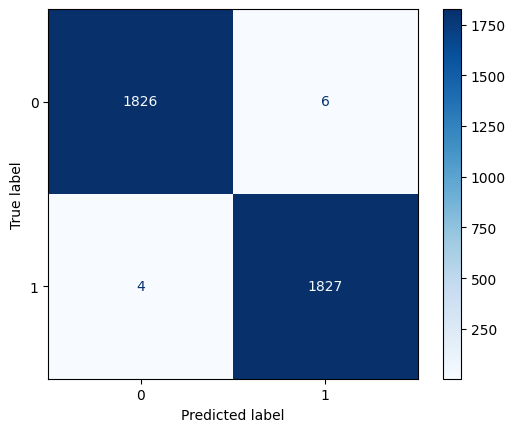

Accuracy:  0.9972699972699973
F1:  0.9972707423580786
Precison:  0.9967266775777414
Recall:  0.997815401419989


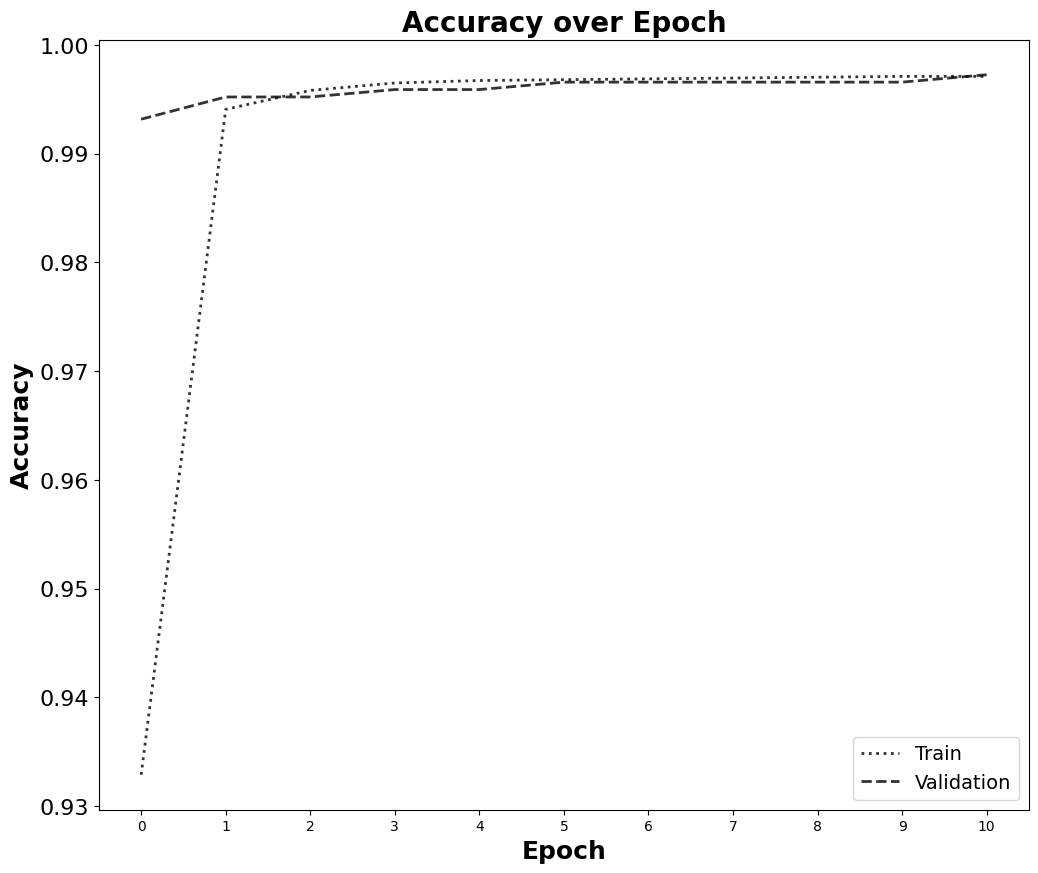

<Figure size 640x480 with 0 Axes>

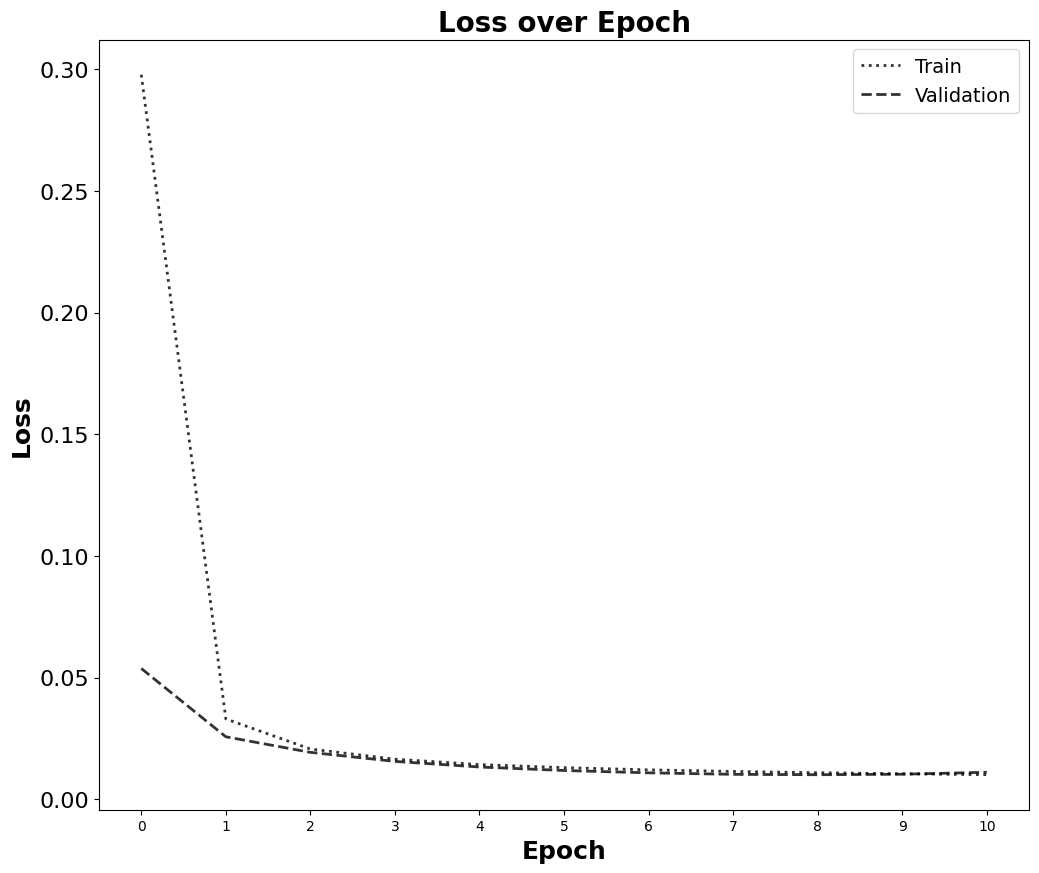

<Figure size 640x480 with 0 Axes>

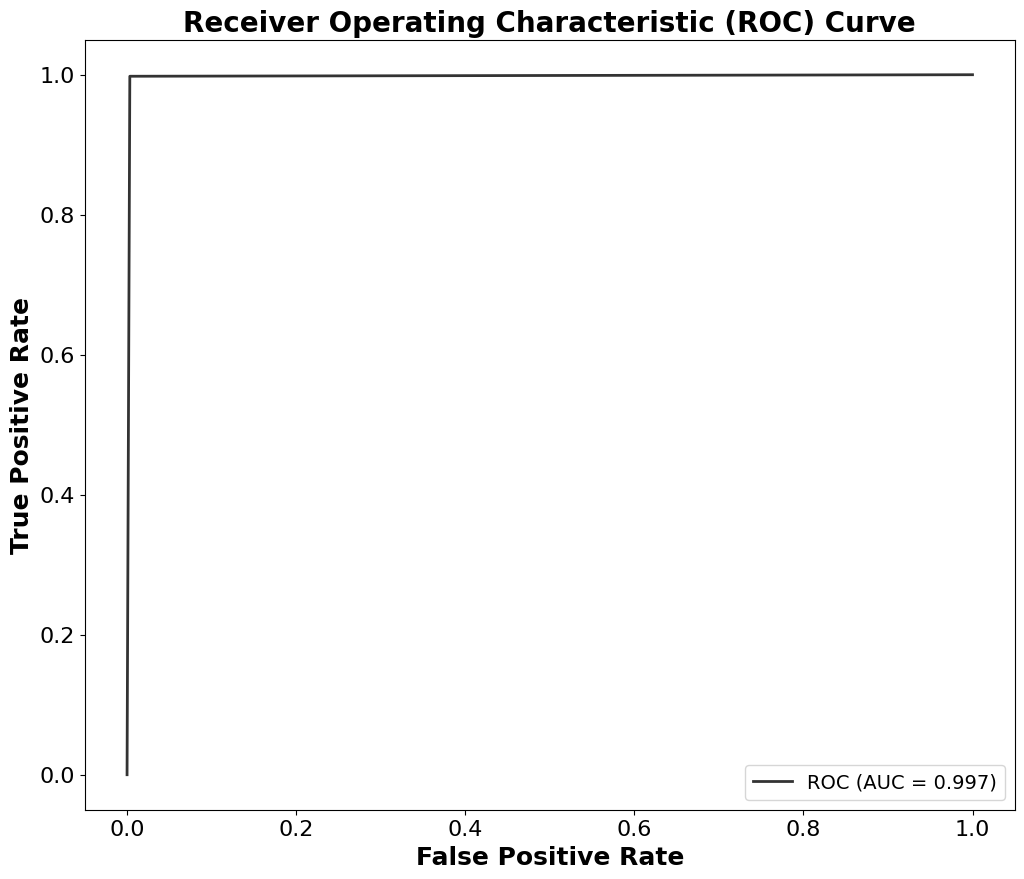

In [13]:
# ============== Training the model ==============
print("X_train: \n", type(X_train), X_train)
print("Y_train: \n", type(Y_train), Y_train)
history = mlp_model_train(X_train, Y_train,
                0.1, # Validation Split
                64, # Batch Size
                100 # Epoch Count
                )

print("history keys: ", history.history.keys())
# ============== Evaluation of the model with actual instances ==============

print("Performance when using actual testing instances")
predictions = mlp_model_eval(X_test, Y_test, history, 1)
plot_acc(Y_test, history, 1)
plot_loss(Y_test, history, 1)
plot_roc(Y_test, predictions, 1)

### Generate adversarial samples for all test datapoints (JSMA)

In [14]:
from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import KerasClassifier

In [15]:
batch_size = 32
# 1) Ensure inputs are float32 in [0, 1]
X_test = X_test.astype("float32")

# 2) Wrap binary model to expose two outputs [1 - p, p]
inp = Input(shape=X_test.shape[1:], dtype=tf.float32)
raw = model(inp)  # builds the Sequential if it wasn't called yet

# Determine output width robustly
n_out = raw.shape[-1] if hasattr(raw, "shape") else tf.keras.backend.int_shape(raw)[-1]

if n_out == 1:
    # If last activation is linear, add sigmoid; otherwise assume it's already sigmoid
    last_act = getattr(model.layers[-1], "activation", tf.keras.activations.linear)
    p = tf.keras.activations.sigmoid(raw) if last_act == tf.keras.activations.linear else raw
    two = Concatenate(axis=-1)([Lambda(lambda t: 1.0 - t)(p), p])  # shape: (None, 2)
else:
    # Already multi-class; keep as-is
    two = raw

wrapped_model = Model(inputs=inp, outputs=two)

# 3) ART classifier: FORCE nb_classes=2 so JSMA never sees a single class
classifier = KerasClassifier(model=wrapped_model,
                             clip_values=(0.0, 1.0))

# 4) JSMA attack
attack = SaliencyMapMethod(classifier=classifier, theta=1.0, gamma=0.1, verbose=False)

# 5) Target vector: class 1 (shape (1, 2))
y_target_vec = np.array([[0.0, 1.0]], dtype=np.float32)

# 6) Build adversarials: modify only class-0 samples; leave class-1 unchanged
# indices of samples whose true class == 0
def label_to_class(y):
    if np.ndim(y) == 0 or (np.ndim(y) == 1 and y.shape[0] == 1):
        return int(y)
    return int(np.argmax(y))

true_classes = np.array([label_to_class(y) for y in Y_test], dtype=int)
indices_to_attack = np.where(true_classes == 0)[0]
X_adv = X_test.copy()
for start in tqdm(range(0, len(indices_to_attack), batch_size)):
    print()
    # if i > 100:
    #   break
    # Accept scalar labels or one-hot labels
    batch_inds = indices_to_attack[start:start + batch_size]
    x_batch = X_test[batch_inds].astype(np.float32)            # shape: (B, ...)
    y_batch = np.tile(y_target_vec, (x_batch.shape[0], 1)).astype(np.float32)  # shape: (B, nb_classes)

    adv_batch = attack.generate(x=x_batch, y=y_batch)          # returns (B, ...)
    X_adv[batch_inds] = adv_batch


/tmp/ipython-input-1965463947.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
  0%|          | 0/58 [00:00<?, ?it/s]

  2%|▏         | 1/58 [00:08<08:16,  8.71s/it]

  3%|▎         | 2/58 [00:15<07:16,  7.80s/it]

  5%|▌         | 3/58 [00:22<06:50,  7.47s/it]

  7%|▋         | 4/58 [00:30<06:38,  7.38s/it]

  9%|▊         | 5/58 [00:37<06:32,  7.40s/it]

 10%|█         | 6/58 [00:44<06:14,  7.20s/it]

 12%|█▏        | 7/58 [00:52<06:19,  7.44s/it]

 14%|█▍        | 8/58 [00:58<05:58,  7.16s/it]

 16%|█▌        | 9/58 [01:07<06:18,  7.73s/it]

 17%|█▋        | 10/58 [01:14<05:51,  7.33s/it]

 19%|█▉        | 11/58 [01:22<05:57,  7.61s/it]

 21%|██        | 12/58 [01:29<05:35,  7.29s/it]

 22%|██▏       | 13/58 [01:36<05:31,  7.37s/it]

 24%|██▍       | 14/58 [01:43<05:11,  7.07s/it]

 26%|██▌       | 15/58 [01:50<05:09,  7.20s/it]

 28%|██▊       | 16/58 [01:57<04:52,  6.97s/it]

 29%|██▉       | 17/58 [02:04<04:56,  7.24s/it]

 31%|███       | 18/58 [02:11<04:40,  7.02s/it]

 33%|███▎      | 19/58 [02:18<04:39,  7.16s/it]

 34%|███▍      | 20/58 [02:25<04:26,  7.01s/it]

 36%|███▌      | 21/58 [02:32<04:22,  7.11s/it]

 38%|███▊      | 22/58 [02:40<04:25,  7.37s/it]

 40%|███▉      | 23/58 [02:47<04:11,  7.19s/it]

 41%|████▏     | 24/58 [02:54<04:03,  7.17s/it]

 43%|████▎     | 25/58 [03:01<03:52,  7.03s/it]

 45%|████▍     | 26/58 [03:08<03:46,  7.09s/it]

 47%|████▋     | 27/58 [03:15<03:35,  6.96s/it]

 48%|████▊     | 28/58 [03:22<03:32,  7.09s/it]

 50%|█████     | 29/58 [03:29<03:19,  6.89s/it]

 52%|█████▏    | 30/58 [03:36<03:15,  6.98s/it]

 53%|█████▎    | 31/58 [03:43<03:07,  6.94s/it]

 55%|█████▌    | 32/58 [03:50<03:06,  7.18s/it]

 57%|█████▋    | 33/58 [03:58<02:59,  7.19s/it]

 59%|█████▊    | 34/58 [04:05<02:55,  7.33s/it]

 60%|██████    | 35/58 [04:12<02:41,  7.02s/it]

 62%|██████▏   | 36/58 [04:19<02:39,  7.23s/it]

 64%|██████▍   | 37/58 [04:26<02:27,  7.04s/it]

 66%|██████▌   | 38/58 [04:34<02:25,  7.28s/it]

 67%|██████▋   | 39/58 [04:40<02:14,  7.09s/it]

 69%|██████▉   | 40/58 [04:48<02:10,  7.25s/it]

 71%|███████   | 41/58 [04:54<01:58,  6.98s/it]

 72%|███████▏  | 42/58 [05:02<01:54,  7.18s/it]

 74%|███████▍  | 43/58 [05:08<01:44,  6.95s/it]

 76%|███████▌  | 44/58 [05:17<01:42,  7.33s/it]

 78%|███████▊  | 45/58 [05:24<01:33,  7.22s/it]

 79%|███████▉  | 46/58 [05:31<01:27,  7.25s/it]

 81%|████████  | 47/58 [05:38<01:19,  7.20s/it]

 83%|████████▎ | 48/58 [05:45<01:11,  7.19s/it]

 84%|████████▍ | 49/58 [05:52<01:04,  7.18s/it]

 86%|████████▌ | 50/58 [05:59<00:57,  7.13s/it]

 88%|████████▊ | 51/58 [06:07<00:51,  7.38s/it]

 90%|████████▉ | 52/58 [06:14<00:42,  7.12s/it]

 91%|█████████▏| 53/58 [06:22<00:36,  7.30s/it]

 93%|█████████▎| 54/58 [06:29<00:28,  7.25s/it]

 95%|█████████▍| 55/58 [06:37<00:22,  7.59s/it]

 97%|█████████▋| 56/58 [06:44<00:14,  7.26s/it]

 98%|█████████▊| 57/58 [06:51<00:07,  7.39s/it]

100%|██████████| 58/58 [06:53<00:00,  7.13s/it]


Performance when using adversarial testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
classification_report
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1832
           1     0.4993    0.9978    0.6656      1831

    accuracy                         0.4988      3663
   macro avg     0.2497    0.4989    0.3328      3663
weighted avg     0.2496    0.4988    0.3327      3663

Confusion Matrix:
 [[   0 1832]
 [   4 1827]]
labels =  None


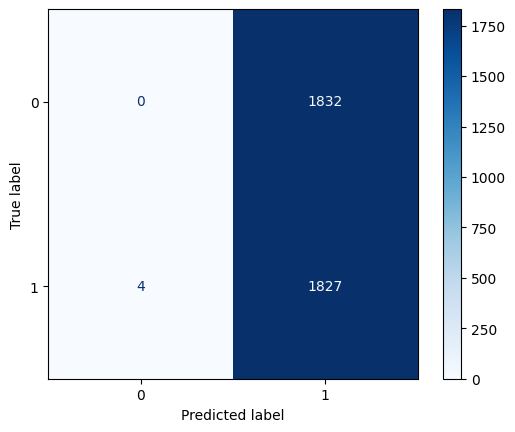

Accuracy:  0.4987714987714988
F1:  0.6655737704918033
Precison:  0.4993167532112599
Recall:  0.997815401419989


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [16]:
# ============== Evaluation of the model with adversarial instances ==============

print("Performance when using adversarial testing instances")
mlp_model_eval(X_adv, Y_test, history, 2)